In [1]:
from matplotlib import pyplot as plt
from scipy.spatial import KDTree
import pandas as pd
from astropy.constants import G
import astropy.units as u
import os
import h5py
from glob import glob
import numpy as np
import matplotlib as mpl


YSO_DIR = glob("../snaps/YSOobjects/" + '/*.hdf5')
DustMaps_DIR = glob("../snaps/snapshot_2000.dustemission.hdf5")

file_1 = YSO_DIR[0]
file_2 = DustMaps_DIR[0]

In [2]:
def read_YSO_data(path):
    with h5py.File(path) as A:
        YSO_X = A["X_pc"][:]
        YSO_Y = A["Y_pc"][:]
        if "Masses" in A:
            YSO_Mass = A["Masses"][:]
        else:
            YSO_Mass = np.zeros(len(YSO_X))
        
    return YSO_X,YSO_Y, YSO_Mass


def read_dust_data(file2):
    with h5py.File(file2) as F:
        X = F["X_pc"][:]
        Y = F["Y_pc"][:]
        Surface_Den = F["SurfaceDensity_Msun_pc2"][:]
        Flattened_Density = (Surface_Den.flatten()) * (u.solMass / u.pc**2)
        dust_cords = np.c_[X.flatten(), Y.flatten()]
    return dust_cords, Flattened_Density

In [3]:
def pixel_neighbor(dust_cords, Flattened_Density, YSO_X, YSO_Y):
    targets = np.c_[YSO_X.flatten(), YSO_Y.flatten()]
    T = KDTree(dust_cords)
    dist, idx = T.query(targets)
    YSOs = targets[:,0]
    YSO_Surface_Den = Flattened_Density[idx]

    return YSOs, YSO_Surface_Den



In [4]:
def SFR_fixed(NYSOs, averageYSO_Mass, tau):
    StarRate = (NYSOs * averageYSO_Mass) /  tau
    return StarRate

In [5]:
def SFR_assumption(NYSOs, averageYSO_Mass, tau):
    StarRate = (NYSOs * averageYSO_Mass) /  tau
    return StarRate

In [6]:
def create_df(file1,file2):
    YSO_X, YSO_Y, YSO_Mass = read_YSO_data(file1)
    dust_cords, Flattened_Density = read_dust_data(file2)
    YSOs, YSO_Surface_Den = pixel_neighbor(dust_cords, Flattened_Density, YSO_X, YSO_Y)

    YSO_frame = pd.DataFrame({ 'YSO_X' : YSO_X, "YSO_Y" : YSO_Y, "YSO Surface Den" : YSO_Surface_Den, "YSO Mass" : YSO_Mass})
    Dust_frame = pd.DataFrame({ 'Dust Coordinates X' : dust_cords[:,0], "Dust Coordinates Y" : dust_cords[:,1], "Flattened Dust Density" : Flattened_Density})
    

    return YSO_frame, Dust_frame
    
    



In [7]:
YSO_frame, Dust_frame = create_df(file_1, file_2)


In [8]:
Dust_frame['Flattened Dust Density'].values

array([0.53638027, 0.5366667 , 0.53687918, ..., 3.39167736, 3.34489014,
       3.30441936])

In [32]:
def SFE(R_I, R_F, YSO_frame, Dust_frame, file2):

    dust_cords, Flattened_Density = read_dust_data(file2)
    Box_Size = 100
    L = Box_Size / 5
    surface_unit = 1 * (u.solMass / u.pc**2)
    YSO_surface_den = YSO_frame["YSO Surface Den"]
    YSO_Masses = YSO_frame["YSO Mass"]
    Flattened_Density = Dust_frame["Flattened Dust Density"].tolist()
    new_G = G.to(u.pc**3/(u.solMass * u.Myr**2)).value
    
    sfe_fixed_list = []
    thresholds  = []
    sfe_og = []
    tff_og = []
    tff_new = []

    sfe_old_sum_list = []
    sfe_new_sum_list = []

    for i in np.arange(R_I, R_F):
        thresholds.append(i)

        Dust_Mask = Dust_frame["Flattened Dust Density"] > (i * surface_unit)
        YSO_Mask = YSO_frame["YSO Surface Den"] > i
        A_i = (L / 1024)**2 * u.pc**2
        A = np.sum(Dust_Mask) *  A_i

        num_yso = (YSO_Mask).sum()
        avg_mass = np.mean((YSO_Masses[YSO_Mask]))
        StarRate = (((num_yso * 0.5) / 0.5) * (u.solMass / u.Myr))

        # Compute alternative SFR using average YSO mass above threshold
        no_assumption_SFR = (((num_yso * avg_mass) / 0.5) * (u.solMass / u.Myr))


        # Compute gas mass and area from the dust data
        M_Gas = np.sum(A_i * Dust_frame["Flattened Dust Density"][Dust_Mask])

        SFR_assum = SFR_fixed(num_yso, 0.5,0.5)
        SFR_no_assum = SFR_assumption(num_yso, avg_mass, 0.5)

        # Compute free-fall time and efficiency if possible
        if M_Gas <= 0 or A.value <= 0:
            sfe_fixed_list.append(np.nan)
            sfe_mean_mass.append(np.nan)
        else:

            t_ff_og = (new_G* (M_Gas / np.sum(A) ** (3/2)))**(-1/2)

            t_ff_num = (np.sum(A ** (3/2))) * np.sqrt(np.pi)

            t_ff_num_new = (np.sum(A) ** (3/2)) * np.sqrt(np.pi)
            t_ff_denom = 8 * new_G * M_Gas
            T_ff = np.sqrt(t_ff_num / t_ff_denom)

            T_ff_new_sum = np.sqrt(t_ff_num_new / t_ff_denom)


            sfe_fixed = (SFR_assum / (M_Gas / T_ff)).value # this SFE has fixed average YSO mass

            sfe_old_sum = (SFR_assum / (M_Gas / T_ff)).value
            sfe_new_sum = (SFR_assum / (M_Gas / T_ff_new_sum)).value

            
            sfe_diff = ( SFR_no_assum / (M_Gas / T_ff)).value

            e_og = (SFR_assum / (M_Gas / t_ff_og)).value 
            
            tff_og.append(t_ff_og)
            tff_new.append(T_ff)
            sfe_og.append(e_og)

            sfe_fixed_list.append(sfe_fixed)
            
            sfe_old_sum_list.append(sfe_old_sum)
            sfe_new_sum_list.append(sfe_new_sum)
        
    return pd.DataFrame({
        "Threshold":   thresholds,
        "SFE Pohkrel T_ff":   sfe_fixed_list,
        "SFE with old Tff": sfe_og,
        "Tff Pohkrel": tff_new,
        "Tff Old": tff_og,
        "SFE Old Sum": sfe_old_sum_list,
        "SFE New Sum": sfe_new_sum_list
        
    })



 

In [35]:
df = SFE(65, 2500, YSO_frame, Dust_frame, file_2)

df

,Threshold,SFE Pohkrel T_ff,SFE with old Tff,Tff Pohkrel,Tff Old,SFE Old Sum,SFE New Sum
0,65,0.022534,0.047873,1.8159479628842203 pc(3/2),3.8579884640692312 pc(3/2),0.022534,0.022534
1,66,0.022517,0.047837,1.7975798423916005 pc(3/2),3.818965321107244 pc(3/2),0.022517,0.022517
2,67,0.022501,0.047803,1.7793576952012338 pc(3/2),3.7802522989899416 pc(3/2),0.022501,0.022501
3,68,0.022487,0.047774,1.7615078957442993 pc(3/2),3.742330331071088 pc(3/2),0.022487,0.022487
4,69,0.022475,0.047747,1.7440069400278133 pc(3/2),3.7051494830267693 pc(3/2),0.022475,0.022475
...,...,...,...,...,...,...,...
2430,2495,0.014589,0.030994,0.06257981313074942 pc(3/2),0.13295105480807906 pc(3/2),0.014589,0.014589
2431,2496,0.014589,0.030994,0.06257981313074942 pc(3/2),0.13295105480807906 pc(3/2),0.014589,0.014589
2432,2497,0.014589,0.030994,0.06257981313074942 pc(3/2),0.13295105480807906 pc(3/2),0.014589,0.014589
2433,2498,0.014589,0.030994,0.06257981313074942 pc(3/2),0.13295105480807906 pc(3/2),0.014589,0.014589


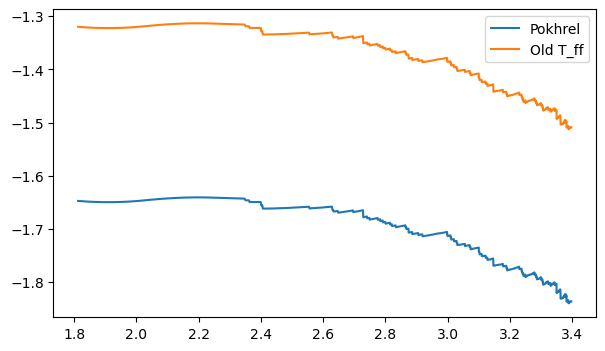

In [41]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(np.log10(df["Threshold"]), np.log10(df["SFE Pohkrel T_ff"]), label= "Pokhrel")
ax.plot(np.log10(df["Threshold"]), np.log10(df["SFE with old Tff"]), label = "Old T_ff")

ax.legend()



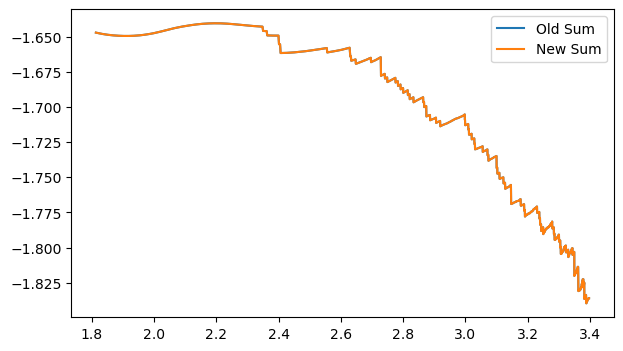

In [43]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(np.log10(df["Threshold"]), np.log10(df["SFE Old Sum"]), label= "Old Sum")
ax.plot(np.log10(df["Threshold"]), np.log10(df["SFE New Sum"]), label = "New Sum")

ax.legend()




In [47]:
# single-cell SFE range calculator

import numpy as np
import pandas as pd
import h5py
from scipy.spatial import KDTree
from astropy.constants import G
import astropy.units as u

# ─── USER PARAMETERS ───────────────────────────────────────────────────────────

Box_Size = 100         # simulation box size (pc)
R_I      = 65          # starting density cutoff
R_F      = 2500        # ending density cutoff (exclusive)
RES      = 1024        # resolution of the dust grid
# ──────────────────────────────────────────────────────────────────────────────

# Read YSO positions & masses
with h5py.File(YSO_DIR[0], "r") as f:
    YSO_X = f["X_pc"][:]
    YSO_Y = f["Y_pc"][:]
    YSO_M = f["Masses"][:] if "Masses" in f else np.zeros_like(YSO_X)

# Read dust grid & flatten
with h5py.File(DustMaps_DIR[0], "r") as f:
    X = f["X_pc"][:]
    Y = f["Y_pc"][:]
    Surface_Den = f["SurfaceDensity_Msun_pc2"][:]
new_den    = Surface_Den.ravel() * (u.solMass / u.pc**2)
dust_coords = np.column_stack([X.ravel(), Y.ravel()])

# Map each YSO to its nearest dust‐cell density
targets = np.column_stack([YSO_X, YSO_Y])
tree    = KDTree(dust_coords)
_, idx  = tree.query(targets)

yso_den = new_den[idx]
yso_m   = YSO_M

# Prepare constants & units
G_pc3 = G.to(u.pc**3/(u.solMass*u.Myr**2)).value
surf_unit = 1 * (u.solMass / u.pc**2)
L = Box_Size / 5

# Loop thresholds and compute SFE
out = []
for thresh in range(R_I, R_F):
    cut = thresh * surf_unit
    mask_ysos = (yso_den > cut)
    N_ysos = mask_ysos.sum()
    # canonical SFR (0.5 YSO in 0.5 Myr each)
    SFR0 = ((N_ysos * 0.5) / 0.5) * (u.solMass / u.Myr)
    # optional mass‐weighted SFR
    avg_m = yso_m[mask_ysos].mean() if N_ysos else 0
    SFR1 = ((N_ysos * avg_m) / 0.5) * (u.solMass / u.Myr)
    # gas mass & area
    mask_gas = (new_den > cut)
    A_i = (L/RES)**2 * u.pc**2
    A   = (mask_gas.sum() * A_i).value
    M_g = (np.sum(A_i * new_den[mask_gas])).value
    # free‐fall time & SFE
    if M_g > 0 and A > 0:
        t_ff = np.sqrt((A**1.5 * np.pi)/(8 * G_pc3 * M_g))
        sfe0  = (SFR0 / (M_g/t_ff)).value
        sfe1  = (SFR1 / (M_g/t_ff)).value
    else:
        sfe0, sfe1 = np.nan, np.nan

    out.append({
        "threshold": thresh,
        "SFE (canonical)": sfe0,
        "SFE (mass-weighted)": sfe1,
        "N_YSOs": N_ysos,
        "M_gas": M_g,
        "Area": A,
        "t_ff (Myr)": t_ff if M_g>0 else np.nan
    })

# Build and show DataFrame
sfe_df = pd.DataFrame(out)
sfe_df


,threshold,SFE (canonical),SFE (mass-weighted),N_YSOs,M_gas,Area,t_ff (Myr)
0,65,0.030000,0.022659,144,11604.713677,84.518051,2.417636
1,66,0.029977,0.022642,144,11496.019173,82.858658,2.393182
2,67,0.029956,0.022626,144,11387.375860,81.224823,2.368922
3,68,0.029938,0.022612,144,11280.156338,79.636383,2.345158
4,69,0.029921,0.022600,144,11174.273676,78.090668,2.321858
...,...,...,...,...,...,...,...
2430,2495,0.019423,0.016352,66,283.111844,0.079727,0.083315
2431,2496,0.019423,0.016352,66,283.111844,0.079727,0.083315
2432,2497,0.019423,0.016352,66,283.111844,0.079727,0.083315
2433,2498,0.019423,0.016352,66,283.111844,0.079727,0.083315


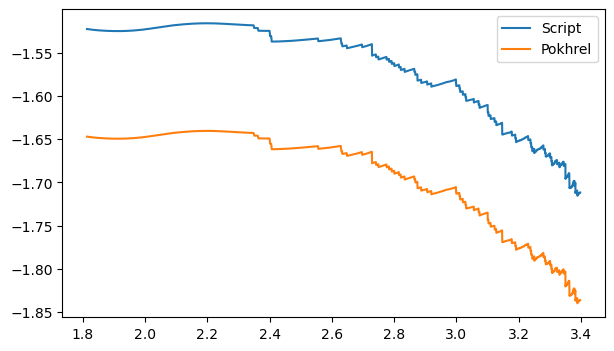

In [50]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(np.log10(sfe_df["threshold"]), np.log10(sfe_df["SFE (canonical)"]), label = "Script")
ax.plot(np.log10(df["Threshold"]), np.log10(df["SFE Pohkrel T_ff"]), label= "Pokhrel")

ax.legend()


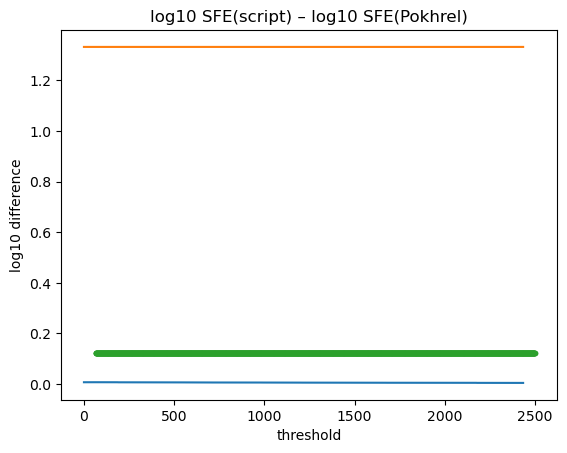

In [53]:
# after merging df and sfe_df on 'threshold':
merged['Δ_linear'] = merged['SFE (canonical)'] - merged['SFE Pohkrel T_ff']
merged['Δ_linear'].plot(title='Linear difference vs. threshold')

merged['ratio'] = merged['SFE (canonical)'] / merged['SFE Pohkrel T_ff']
merged['ratio'].plot(title='Linear ratio vs. threshold')

logdiff = np.log10(merged['SFE (canonical)']) - np.log10(merged['SFE Pohkrel T_ff'])
plt.plot(merged['threshold'], logdiff, marker='.')
plt.xlabel('threshold')
plt.ylabel('log10 difference')
plt.title('log10 SFE(script) – log10 SFE(Pokhrel)')
plt.show()
